# **Method 1 : Straightforward approach**

**Model hypothesis:**
* Autonomous RNN with a 3 hidden layers MLP.
* Inputs = [ Chl ; Phy ] (t - 1)
* Ouputs = [ Chl ; Phy ] (t)

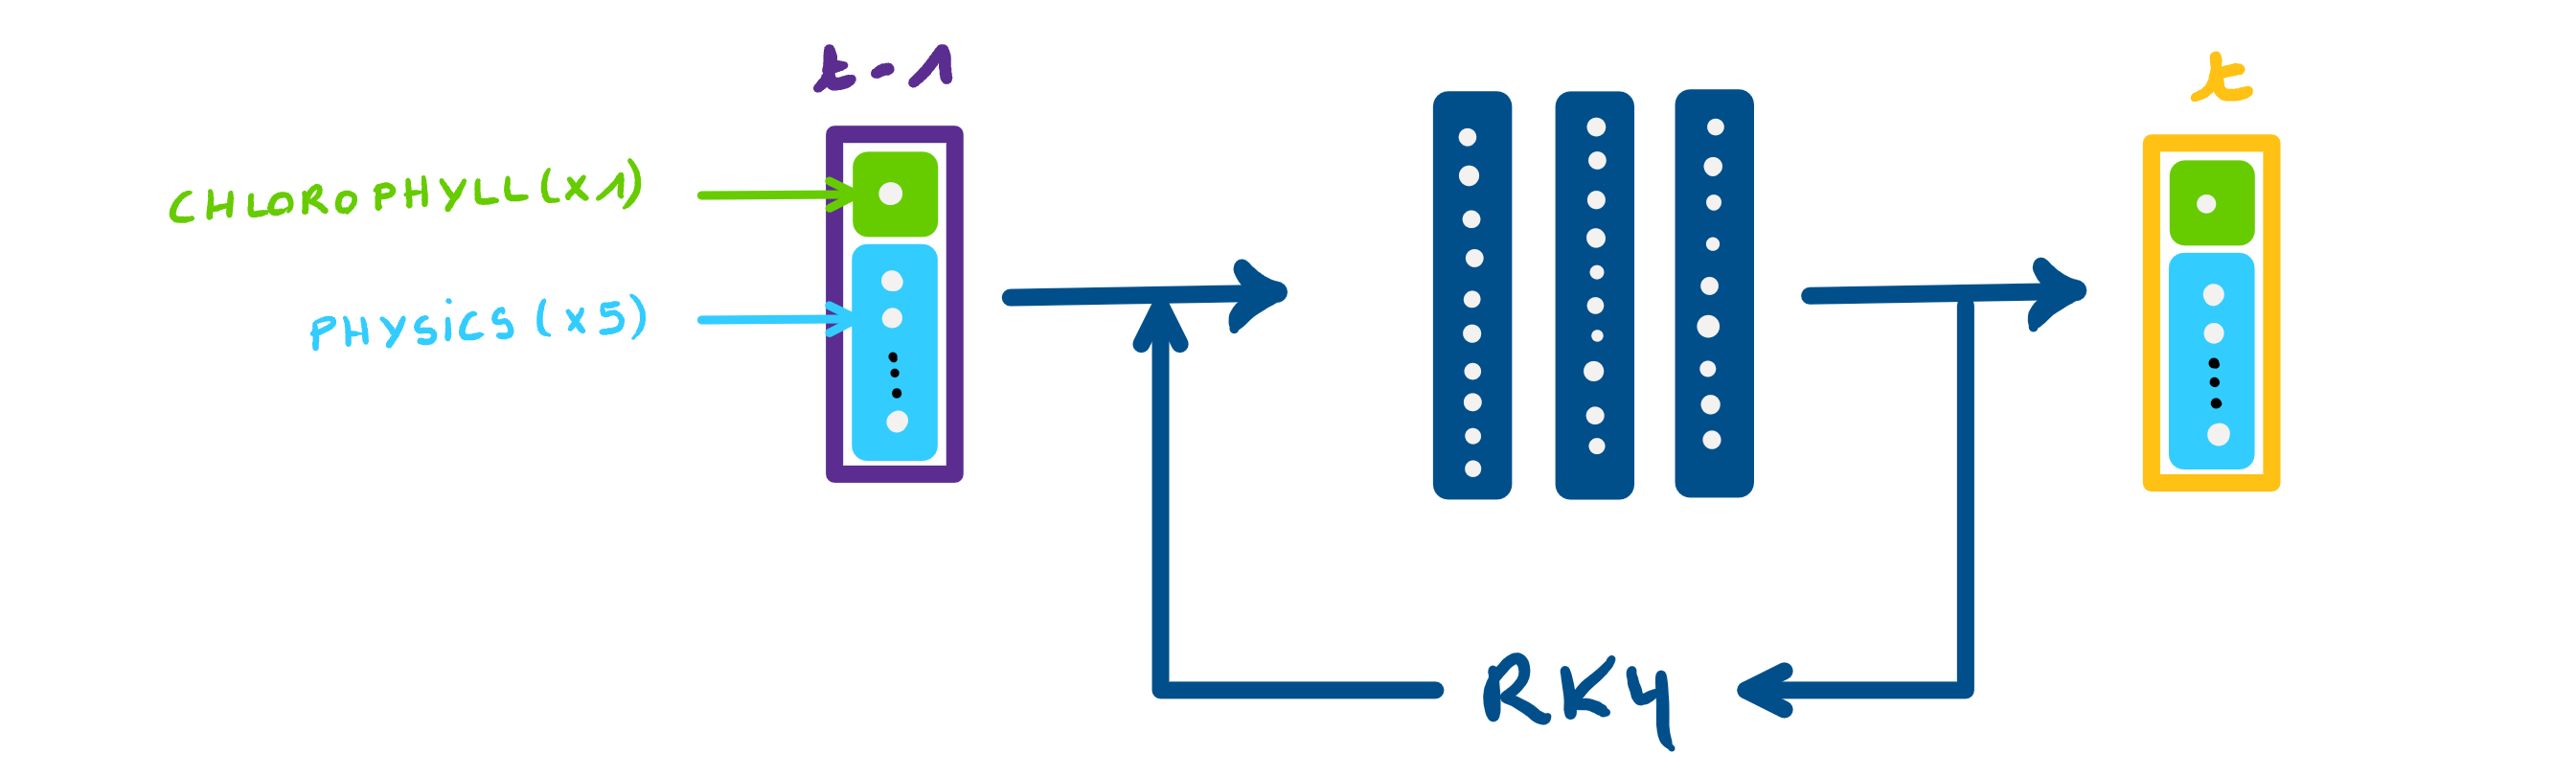

> ## **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> ## **Load the formated data**

In [3]:
directory = '/content/drive/My Drive/Colab Notebooks/North_Sea/'
exec(open(directory + 'src/inputs_method1.py').read())

P1    = [1960;1980]      <=> Indices = [0;234]
P2    = [1981;2010]      <=> Indices = [246;587]
SHIFT = [1981;1989] ⊂ P2 <=> Indices = [246;342]

Input vector shape : (588, 6)

Train set size : 234 and variance_train = 1.000
Train vectors shapes : (234, 6) (234, 6) (234, 1)

Test  set size : 341 and variance_test  = 1.241
Test  vectors shapes : (341, 6) (341, 6) (341, 1)


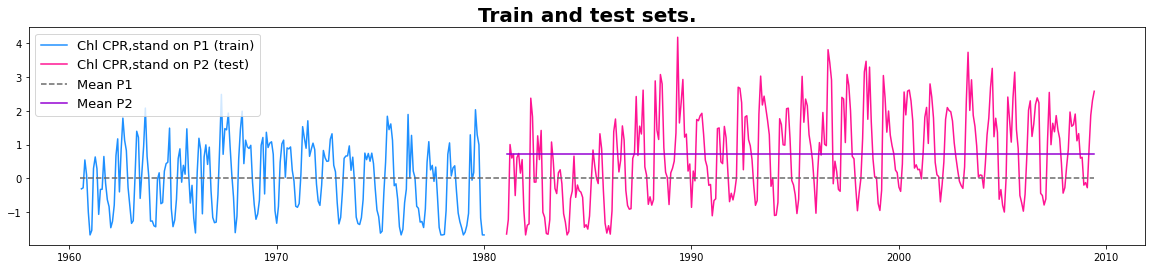

In [4]:
time_years, inp_train, inp_true_train, dt_train, time_years_train, var_train, inp_test, inp_true_test, dt_test, time_years_test, var_test = inputs_1(directory)

> ## **Model settings**

In [5]:
params = {}
params['dim_chloro'] = 1
params['dim_phy'] = 5
params['dim_input'] = params['dim_chloro'] + params['dim_phy']
params['dim_hidden_1'] = 32
params['dim_hidden_2'] = 28
params['dim_hidden_3'] = 14
params['dim_output'] = params['dim_input']
params['batchsize'] = 50
params['epoch'] = 200
params['nb_batch'] = len(time_years)//params['batchsize'] + 1 
params['dt_horizon'] = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idx1980 = np.where(np.round(time_years,1) == 1980)[0][0]

In [6]:
exec(open(directory + 'src/RNN.py').read())
model_RNN = INT_net(params)

In [7]:
batchsize = params['batchsize']

training_dataset = torch.utils.data.TensorDataset(torch.Tensor(inp_train), torch.Tensor(dt_train), torch.Tensor(inp_true_train))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(inp_test), torch.Tensor(dt_test), torch.Tensor(inp_true_test))

dataloaders = {'train': torch.utils.data.DataLoader(training_dataset, batch_size = batchsize, shuffle=False, num_workers=2, pin_memory=True), 'test': torch.utils.data.DataLoader(test_dataset, batch_size = batchsize, shuffle=False, num_workers=2, pin_memory=True)}

num_epochs = params['epoch']
optimizer = optim.Adam(model_RNN.parameters(), lr = 1e-3)

> ## **Training**

... Var of training set = 1.000
... Var of test set     = 1.241

Epoch [1 / 200] : Training data -- loss 29.769 ; Testing data -- loss 30.210
Epoch [11 / 200] : Training data -- loss 23.647 ; Testing data -- loss 25.624
Epoch [21 / 200] : Training data -- loss 21.036 ; Testing data -- loss 23.992
Epoch [31 / 200] : Training data -- loss 20.218 ; Testing data -- loss 23.504
Epoch [41 / 200] : Training data -- loss 19.918 ; Testing data -- loss 23.861
Epoch [51 / 200] : Training data -- loss 19.798 ; Testing data -- loss 24.151
Epoch [61 / 200] : Training data -- loss 19.739 ; Testing data -- loss 24.256
Epoch [71 / 200] : Training data -- loss 19.707 ; Testing data -- loss 24.316
Epoch [81 / 200] : Training data -- loss 19.690 ; Testing data -- loss 24.411
Epoch [91 / 200] : Training data -- loss 19.685 ; Testing data -- loss 24.463
Epoch [101 / 200] : Training data -- loss 19.678 ; Testing data -- loss 24.573
Epoch [111 / 200] : Training data -- loss 19.679 ; Testing data -- loss 24.57

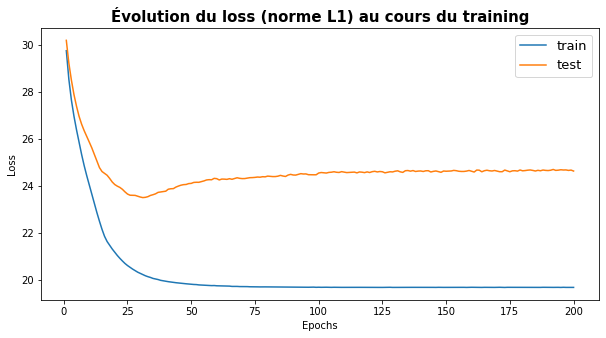

In [8]:
x_epoch = np.arange(1, num_epochs+1, 1)

NL1_train = np.zeros(num_epochs)
NL1_test  = np.zeros(num_epochs)

print('... Var of training set = %.3f' %var_train)
print('... Var of test set     = %.3f' %var_test)
print()

model_RNN.to(device)
model_RNN.float()
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train' :
          model_RNN.train()
        else:
          model_RNN.eval() 

        loss_all = 0.
        num_all = 0
        
        for i, data in enumerate(dataloaders[phase]):
            model_RNN.zero_grad()
            optimizer.zero_grad()
            
            inp = data[0].to(device)
            dt = data[1].to(device)
            true = data[2].to(device)

            pred = model_RNN(inp, dt)

            loss = torch.sum(abs(pred - true))
            if phase == 'train' :
                loss.backward()
                optimizer.step()
            
            loss_all = loss_all + loss.cpu().detach().numpy() * inp.size(0)
                
            num_all  += inp.shape[0]

        if phase == 'train' :
            NL1_train[epoch] = loss_all / (num_all * inp.shape[1])

        else :
            NL1_test[epoch] = loss_all / (num_all * inp.shape[1])

    if epoch%10 == 0:
        print("Epoch [%d / %d] : Training data -- loss %.3f ; Testing data -- loss %.3f"%(epoch+1, num_epochs, NL1_train[epoch], NL1_test[epoch]))

plt.figure(figsize = (10,5))
plt.plot(x_epoch, NL1_train, label = 'train')
plt.plot(x_epoch, NL1_test, label = 'test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Évolution du loss (norme L1) au cours du training", size = 15, fontweight = 'bold')
plt.legend(prop = {'size' : 13})

>> ## **Model Chl reconstruction**

In [9]:
exec(open(directory + 'src/plots.py').read())

model_RNN.double()

NN_outputs_test = []
Chl_stand_test  = inp_true_test[:,0].reshape(1,-1)[0]
old_pred = torch.from_numpy(inp_test[0]).view(1,-1)
for i in range(len(inp_test)):
    pred = model_RNN(old_pred, torch.from_numpy(dt_test[i]).view(1,-1))
    old_pred = torch.cat((pred[0,0].view(1,-1), torch.from_numpy(inp_true_test)[i,1:].view(1,-1)), axis = 1)
    NN_outputs_test.append(pred.cpu().detach().numpy()[0][0])
MSE_test = np.mean((Chl_stand_test - NN_outputs_test)**2/var_test)


NN_outputs_train = []
Chl_stand_train = inp_true_train[:,0].reshape(1,-1)[0]
old_pred = torch.from_numpy(inp_train[0]).view(1,-1)
for i in range(len(inp_train)):
    pred = model_RNN(old_pred, torch.from_numpy(dt_train[i]).view(1,-1))
    old_pred = torch.cat((pred[0,0].view(1,-1), torch.from_numpy(inp_true_train)[i,1:].view(1,-1)), axis = 1)
    NN_outputs_train.append(pred.cpu().detach().numpy()[0][0])
MSE_train = np.mean((Chl_stand_train - NN_outputs_train)**2/var_train)

>> ### **Reconstruction on P1+P2** 

In [10]:
### CHANGE YOUR GRAPHIC PREFERENCES (LINECOLOR, LINESTYLE, FONTSIZE, LABELS...) THE WAY YOU WANT
## CHL MLP TEST GRAPHIC STYLE
pred_test_style = {}

pred_test_style['color'] = 'crimson'
pred_test_style['label'] = None
pred_test_style['linewidth'] = 1.5
pred_test_style['linestyle'] = 'solid'
pred_test_style['marker'] = None

pred_test_style['mean_color'] = 'crimson'
pred_test_style['mean_label'] = None
pred_test_style['mean_linewidth'] = 1.5
pred_test_style['mean_linestyle'] = 'solid'

## CHL MLP TRAIN GRAPHIC STYLE
pred_train_style = {}

pred_train_style['color'] = 'crimson'
pred_train_style['label'] = 'Chl MLP, P1 (train) : ' + str(round(MSE_train,4)) + '\n' + 'Chl MLP, P2 (test) : ' + str(round(MSE_test, 4))
pred_train_style['linewidth'] = 1.5
pred_train_style['linestyle'] = 'solid'
pred_train_style['marker'] = None

pred_train_style['mean_color'] = 'crimson'
pred_train_style['mean_label'] = None
pred_train_style['mean_linewidth'] = 1.5
pred_train_style['mean_linestyle'] = 'solid'

## CHL CPR GRAPHIC STYLE
Chl_style = {}

Chl_style['color'] = 'royalblue'
Chl_style['label'] = 'Chl CPR'
Chl_style['linewidth'] = 1.5
Chl_style['linestyle'] = 'solid'
Chl_style['marker'] = None

Chl_style['mean_all_color'] = 'dimgrey'
Chl_style['mean_all_label'] = None
Chl_style['mean_all_linewidth'] = 1.5
Chl_style['mean_all_linestyle'] = 'dashed'

Chl_style['mean_test_color'] = 'royalblue'
Chl_style['mean_test_label'] = None
Chl_style['mean_test_linewidth'] = 1.5
Chl_style['mean_test_linestyle'] = 'solid'

Chl_style['mean_train_color'] = 'royalblue'
Chl_style['mean_train_label'] = None
Chl_style['mean_train_linewidth'] = 1.5
Chl_style['mean_train_linestyle'] ='solid'

graph_settings = {}
graph_settings['figsize'] = (20,4)
graph_settings['xlabel'] = 'time (years)'
graph_settings['ylabel'] = 'Chl anomalies'
graph_settings['title'] = 'Chl CPR anomalies and Chl MLP anomalies on P1 ([1960;1980]) and P2 ([1981;2010]).'
graph_settings['title_size'] = 20
graph_settings['legend_size'] = 13

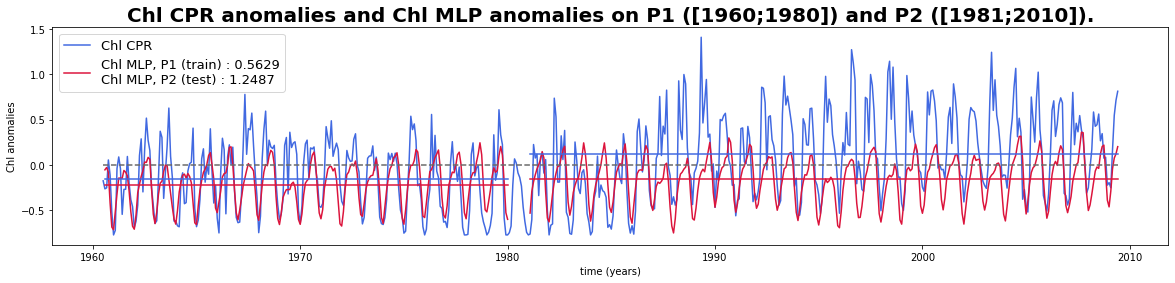

In [11]:
time_serie_all(directory, NN_outputs_test, NN_outputs_train, Chl_stand_test, Chl_stand_train, pred_test_style, pred_train_style, Chl_style, graph_settings)

>> ### **Reconstruction on P2 (test period)**

In [12]:
## ADD/CHANGE USEFUL KEYS FOR P2 MLP RECONSTRUCTION
Chl_style['test_label'] = 'Chl CPR P2'
Chl_style['mean_test_color'] = 'blue'
Chl_style['mean_test_label'] = 'Mean Chl CPR P2'
Chl_style['mean_test_linestyle'] = 'dashed'
Chl_style['train_label'] = 'Chl CPR P1'
Chl_style['mean_train_color'] = 'black'
Chl_style['mean_train_label'] = 'Mean Chl CPR P1'
Chl_style['mean_train_linestyle'] = 'dashed'

graph_settings['title'] = "Chl CPR anomalie and Chl MLP anomalies on P2([1981;2010])."

pred_test_style['label'] = 'Chl MLP P2 (test):%.4f'%MSE_test
pred_test_style['mean_color'] = 'red'
pred_test_style['mean_label'] = 'Mean Chl MLP P2'
pred_test_style['mean_linestyle'] = 'dashed'

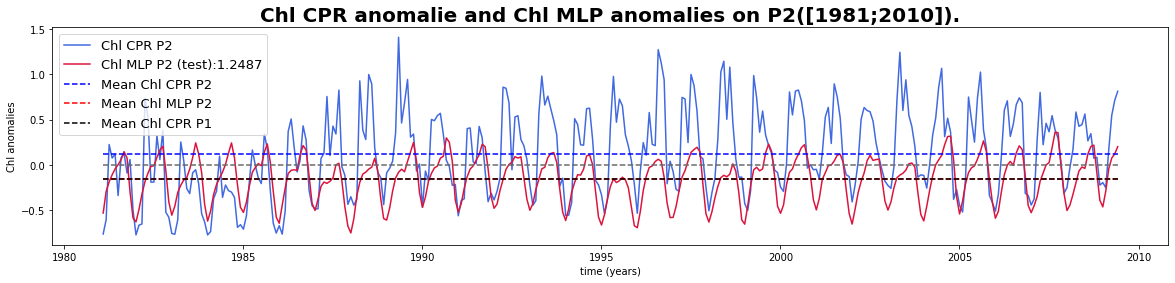

In [13]:
time_serie_test(directory, NN_outputs_test, Chl_stand_test, Chl_stand_train, pred_test_style, Chl_style, graph_settings)

>> ### **Annual means and cumulated sums**

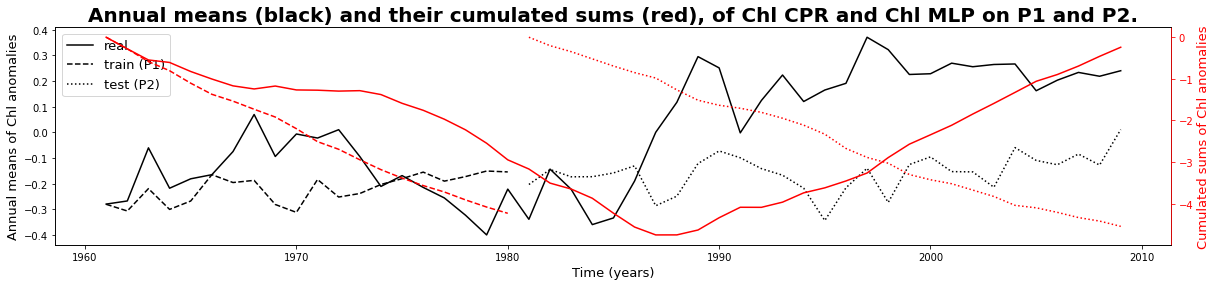

In [14]:
annualMeans(directory, NN_outputs_test, NN_outputs_train, Chl_stand_test, Chl_stand_train)

>> ### **Scatter plots**

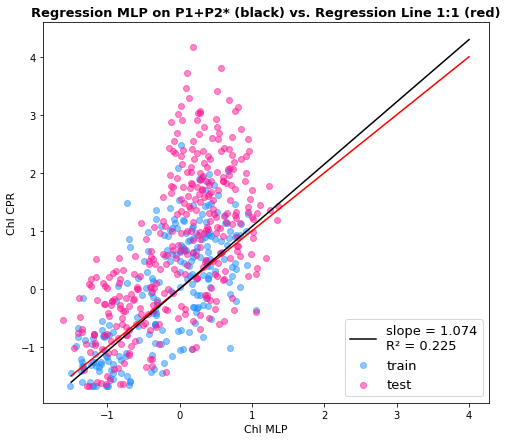

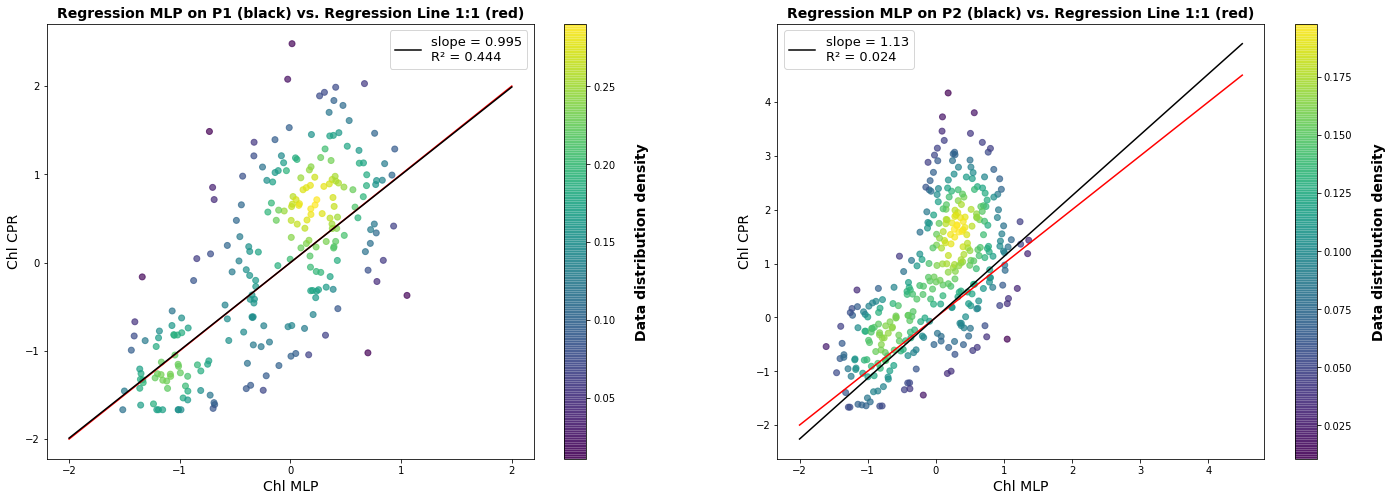

In [15]:
scatterplots(NN_outputs_test, NN_outputs_train, Chl_stand_test, Chl_stand_train)

> ## **Model saving**

In [16]:
## SAVE THE MODEL WEIGHTS IN THE 'MODELS' FILE
torch.save(model_RNN.state_dict(), directory + 'models/model_1_weights.pth')